In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,GlobalAveragePooling1D,Embedding
from tensorflow.keras.initializers import Constant

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
from sklearn.metrics import precision_score, recall_score, f1_score,accuracy_score
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt

import tensorflow as tf
print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("GPU is", "available" if tf.test.is_gpu_available() else "NOT AVAILABLE")

Version:  1.15.0
Eager mode:  False
GPU is available


In [2]:
df = pd.read_csv('../test_30k.csv')
df = df[['bucket_name','description','product_name']]
# to lowercase
df.bucket_name = df.bucket_name.apply(lambda x : x.lower())
df.description = df.description.apply(lambda x : str(x).lower())
df.product_name = df.product_name.apply(lambda x : str(x).lower())
df.head()

,bucket_name,description,product_name
0,food decorating tools & presentation accessories,don't keep your guests guessing at your next d...,"chalkboard gift tags black pkg/5 3"" x 1-1/2"""
1,food decorating tools & presentation accessories,don't keep your guests guessing at your next d...,ingredient spring stainless steel pkg/4 1-1/4...
2,food decorating tools & presentation accessories,don't keep your guests guessing at your next d...,chalk markers chisel tip classic pkg/8
3,food decorating tools & presentation accessories,add a personalized touch to party tables with ...,fine tip chalk markers white pkg/2
4,food decorating tools & presentation accessories,add a personalized touch to party tables with ...,fine tip chalk markers white pkg/2


In [3]:
df['bucket_name'].value_counts()

glasses                                                               4335
tableware variety packs                                               3501
plates & platters                                                     2758
tablecloths & table runners                                           1959
bowls                                                                 1943
food storage canisters/containers & accessories                       1531
mugs/teacups/cups                                                     1233
napkins                                                               1138
coolers & food carriers                                               1108
placemats                                                             1071
trays & boards                                                         866
kitchen/dishtowels & dishcloths                                        791
vacuum/water bottles & travel mugs                                     781
flatware sets            

In [4]:
print("categories:",len(df.bucket_name.unique()))
CLASSES = LabelEncoder()
df['label']=CLASSES.fit_transform(df['bucket_name'])
df.head()
NUM_OF_CLASS=len(CLASSES.classes_)
label = df.label.tolist()


categories: 77


In [5]:
CLASSES.classes_

array(['aprons', 'baking dishes', 'baking sheets & baking pans',
       'blenders', 'bottle stoppers & pourers', 'bowls',
       'chopping/slicing/cutting boards', 'coasters',
       'cocktail preparation tools', 'coffee, tea, & espresso makers',
       'coffee, tea, & espresso preparation tools',
       'colanders & strainers', 'cooking utensils variety packs',
       'cooking/baking spoons & spatulas',
       'cookware & bakeware replacement parts & accessories',
       'cookware & bakeware storage racks',
       'cookware & bakeware variety packs', 'coolers & food carriers',
       'cruets & sprayers', 'decanters', 'dish drying racks & mats',
       'dispensers', 'disposable food storage', 'dough & baking tools',
       'dutch ovens & braisers', 'flatware sets',
       'food & beverage preparation device accessories & replacement parts',
       'food decorating tools & presentation accessories',
       'food preparation/mixing bowls', 'food processors',
       'food storage baskets'

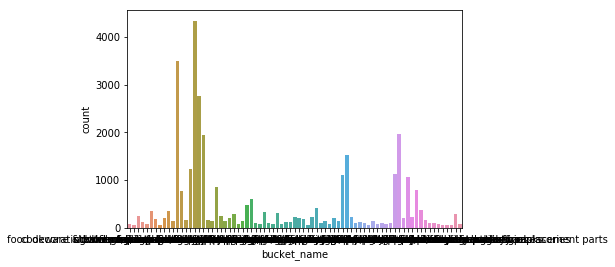

In [6]:
ax = sns.countplot(x="bucket_name", data=df)

In [7]:

#plot history function.
def plotresult(History):
    %matplotlib inline
    plt.figure(figsize=(10,4))
    plt.subplot(2,2,1)
    plt.plot(History.history['acc'])

    plt.ylabel('Accuracy %')
    plt.title('Training')
    plt.subplot(2,2,2)
    plt.plot(History.history['val_acc'])
    plt.title('Validation')

    plt.subplot(2,2,3)
    plt.plot(History.history['loss'])
    plt.ylabel('categorical_crossentropy Training Loss')
    plt.xlabel('epochs')

    plt.subplot(2,2,4)
    plt.plot(History.history['val_loss'])
    plt.xlabel('epochs')
    
def get_token_for_sentence(corpus):
#     corpus = df.description.tolist()


    vocabulary_size = 20000
    tokenizer = Tokenizer(num_words= vocabulary_size, 
                          filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', 
                          lower=True, 
                          split=' ')

    tokenizer.fit_on_texts(corpus)
    sequences = tokenizer.texts_to_sequences(corpus)

    top_word = len(tokenizer.index_word) +1
    print("vocab:",top_word)
    return sequences

In [8]:
name_token = get_token_for_sentence(df.product_name.tolist())
des_token = get_token_for_sentence(df.description.tolist())


vocab: 7427
vocab: 21117


In [9]:
from __future__ import print_function
import numpy as np

from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Embedding
from keras.layers import GlobalAveragePooling1D


def create_ngram_set(input_list, ngram_value=2):
    """
    Extract a set of n-grams from a list of integers.

    >>> create_ngram_set([1, 4, 9, 4, 1, 4], ngram_value=2)
    {(4, 9), (4, 1), (1, 4), (9, 4)}

    >>> create_ngram_set([1, 4, 9, 4, 1, 4], ngram_value=3)
    [(1, 4, 9), (4, 9, 4), (9, 4, 1), (4, 1, 4)]
    """
    return set(zip(*[input_list[i:] for i in range(ngram_value)]))


def add_ngram(sequences, token_indice, ngram_range=2):
    """
    Augment the input list of list (sequences) by appending n-grams values.

    Example: adding bi-gram
    >>> sequences = [[1, 3, 4, 5], [1, 3, 7, 9, 2]]
    >>> token_indice = {(1, 3): 1337, (9, 2): 42, (4, 5): 2017}
    >>> add_ngram(sequences, token_indice, ngram_range=2)
    [[1, 3, 4, 5, 1337, 2017], [1, 3, 7, 9, 2, 1337, 42]]

    Example: adding tri-gram
    >>> sequences = [[1, 3, 4, 5], [1, 3, 7, 9, 2]]
    >>> token_indice = {(1, 3): 1337, (9, 2): 42, (4, 5): 2017, (7, 9, 2): 2018}
    >>> add_ngram(sequences, token_indice, ngram_range=3)
    [[1, 3, 4, 5, 1337, 2017], [1, 3, 7, 9, 2, 1337, 42, 2018]]
    """
    new_sequences = []
    for input_list in sequences:
        new_list = input_list[:]
        for ngram_value in range(2, ngram_range + 1):
            for i in range(len(new_list) - ngram_value + 1):
                ngram = tuple(new_list[i:i + ngram_value])
                if ngram in token_indice:
                    new_list.append(token_indice[ngram])
        new_sequences.append(new_list)

    return new_sequences

In [10]:
def eval_model(x_train, x_test, y_train, y_test,maxlen,fold_number,ngram_range,feature):
    current_model_name = "model/"+feature+"_ngram_"+str(ngram_range) + "_fold_"+str(fold_number)+"_best.h5"


    max_features = 20000
#     maxlen = 50
    batch_size = 32
    embedding_dims = 50
    epochs = 35
    Patience = 3
    
    print(len(x_train), 'train sequences')
    print(len(x_test), 'test sequences')
    print('Average train sequence length: {}'.format(
        np.mean(list(map(len, x_train)))))
    print('Average test sequence length: {}'.format(
        np.mean(list(map(len, x_test)))))

    if ngram_range > 1:
        print('Adding {}-gram features'.format(ngram_range))
        # Create set of unique n-gram from the training set.
        ngram_set = set()
        for input_list in x_train:
            for i in range(2, ngram_range + 1):
                set_of_ngram = create_ngram_set(input_list, ngram_value=i)
                ngram_set.update(set_of_ngram)

        # Dictionary mapping n-gram token to a unique integer.
        # Integer values are greater than max_features in order
        # to avoid collision with existing features.
        start_index = max_features + 1
        token_indice = {v: k + start_index for k, v in enumerate(ngram_set)}
        indice_token = {token_indice[k]: k for k in token_indice}

        # max_features is the highest integer that could be found in the dataset.
        max_features = np.max(list(indice_token.keys())) + 1
        print("max_features:",max_features)

        # Augmenting x_train and x_test with n-grams features
        x_train = add_ngram(x_train, token_indice, ngram_range)
        x_test = add_ngram(x_test, token_indice, ngram_range)
        print('Average train sequence length: {}'.format(
            np.mean(list(map(len, x_train)), dtype=int)))
        print('Average test sequence length: {}'.format(
            np.mean(list(map(len, x_test)), dtype=int)))

    print('Pad sequences (samples x time)')
    x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
    x_test = sequence.pad_sequences(x_test, maxlen=maxlen)
    print('x_train shape:', x_train.shape)
    print('x_test shape:', x_test.shape)

    print('Build model...')
    model = Sequential()

    # we start off with an efficient embedding layer which maps
    # our vocab indices into embedding_dims dimensions
    model.add(Embedding(max_features,
                        embedding_dims,
                        input_length=maxlen))

    # we add a GlobalAveragePooling1D, which will average the embeddings
    # of all words in the document
    model.add(GlobalAveragePooling1D())

    # We project onto a single unit output layer, and squash it with a sigmoid:
    model.add(Dense(NUM_OF_CLASS, activation='softmax'))

    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    # print(model.summary())
    checkpoint = ModelCheckpoint(current_model_name, monitor='val_acc', verbose=0, save_best_only=True, mode='max')
    history = model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              callbacks=[EarlyStopping(monitor='val_loss', patience=Patience),checkpoint], 
              verbose=1 )
    
    model.load_weights(current_model_name)
#     yhat = np.argmax(model.predict(x_test),axis=1)
#     return f1_score(y_test,yhat,average='macro')
    yhat = model.predict(x_test)
    return yhat


In [11]:
# def eval_model_fusion(x_train, x_test, y_train, y_test,maxlen,fold_number,ngram_range,feature):
#     current_model_name = "model/"+feature+"_ngram_"+str(ngram_range) + "_fold_"+str(fold_number)+"_best.h5"


#     max_features = 20000
# #     maxlen = 50
#     batch_size = 32
#     embedding_dims = 50
#     epochs = 35
#     Patience = 3
    
#     print(len(x_train), 'train sequences')
#     print(len(x_test), 'test sequences')
#     print('Average train sequence length: {}'.format(
#         np.mean(list(map(len, x_train)))))
#     print('Average test sequence length: {}'.format(
#         np.mean(list(map(len, x_test)))))

#     if ngram_range > 1:
#         print('Adding {}-gram features'.format(ngram_range))
#         # Create set of unique n-gram from the training set.
#         ngram_set = set()
#         for input_list in x_train:
#             for i in range(2, ngram_range + 1):
#                 set_of_ngram = create_ngram_set(input_list, ngram_value=i)
#                 ngram_set.update(set_of_ngram)

#         # Dictionary mapping n-gram token to a unique integer.
#         # Integer values are greater than max_features in order
#         # to avoid collision with existing features.
#         start_index = max_features + 1
#         token_indice = {v: k + start_index for k, v in enumerate(ngram_set)}
#         indice_token = {token_indice[k]: k for k in token_indice}

#         # max_features is the highest integer that could be found in the dataset.
#         max_features = np.max(list(indice_token.keys())) + 1
#         print("max_features:",max_features)

#         # Augmenting x_train and x_test with n-grams features
#         x_train = add_ngram(x_train, token_indice, ngram_range)
#         x_test = add_ngram(x_test, token_indice, ngram_range)
#         print('Average train sequence length: {}'.format(
#             np.mean(list(map(len, x_train)), dtype=int)))
#         print('Average test sequence length: {}'.format(
#             np.mean(list(map(len, x_test)), dtype=int)))

#     print('Pad sequences (samples x time)')
#     x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
#     x_test = sequence.pad_sequences(x_test, maxlen=maxlen)
#     print('x_train shape:', x_train.shape)
#     print('x_test shape:', x_test.shape)

#     print('Build model...')
#     model = Sequential()

#     # we start off with an efficient embedding layer which maps
#     # our vocab indices into embedding_dims dimensions
#     model.add(Embedding(max_features,
#                         embedding_dims,
#                         input_length=maxlen))

#     # we add a GlobalAveragePooling1D, which will average the embeddings
#     # of all words in the document
#     model.add(GlobalAveragePooling1D())

#     # We project onto a single unit output layer, and squash it with a sigmoid:
#     model.add(Dense(NUM_OF_CLASS, activation='softmax'))

#     model.compile(loss='sparse_categorical_crossentropy',
#                   optimizer='adam',
#                   metrics=['accuracy'])

#     # print(model.summary())
#     checkpoint = ModelCheckpoint(current_model_name, monitor='val_acc', verbose=0, save_best_only=True, mode='max')
#     history = model.fit(x_train, y_train,
#               batch_size=batch_size,
#               epochs=epochs,
#               validation_data=(x_test, y_test),
#               callbacks=[EarlyStopping(monitor='val_loss', patience=Patience),checkpoint], 
#               verbose=1 )
    
#     model.load_weights(current_model_name)
# #     yhat = np.argmax(model.predict(x_test),axis=1)
# #     return f1_score(y_test,yhat,average='macro')
#     yhat = model.predict(x_test)
#     return yhat


In [12]:
# Set parameters:
# ngram_range = 2 will add bi-grams features

score = []

X = np.array(name_token)
X_des = np.array(des_token)
y = np.array(label)
skf = StratifiedKFold(n_splits=5)
skf.get_n_splits(X, y)


fold = 1
for train_index, test_index in skf.split(X, y):

    print("in Fold ", fold)
    x_train, x_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    name_yhat = eval_model(x_train, x_test, y_train, y_test,maxlen=16,fold_number=fold,ngram_range=1,feature='name')

    
    x_train, x_test = X_des[train_index], X_des[test_index]
    y_train, y_test = y[train_index], y[test_index]
    des_yhat = eval_model(x_train, x_test, y_train, y_test,maxlen=50,fold_number=fold,ngram_range=2,feature='description')

    yhat = np.argmax(name_yhat+des_yhat,axis=1)
    
    
    score.append(f1_score(y_test,yhat,average='macro'))
    print(classification_report(y_test, yhat, target_names=CLASSES.classes_))
    fold+=1




in Fold  1
27039 train sequences
6803 test sequences
Average train sequence length: 6.373719442287067
Average test sequence length: 6.693076583860062
Pad sequences (samples x time)
x_train shape: (27039, 16)
x_test shape: (6803, 16)
Build model...
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Train on 27039 samples, validate on 6803 samples
Epoch 1/35
27039/27039 [==============================] - 5s 170us/step - loss: 3.1961 - acc: 0.2850 - val_loss: 2.6096 - val_acc: 0.4524
Epoch 2/35
27039/27039 [==============================] - 3s 103us/step - loss: 1.8510 - acc: 0.6503 - val_loss: 1.6897 - val_acc: 0.6746
Epoch 3/35
27039/27039 [==============================] - 3s 95us/step - loss: 1.1123 - acc: 0.7726 - val_loss: 1.2490 - val_acc: 0.7561
Epoch 4/35
27039/27039 [==============================] - 3s 95us/step - loss: 0.7688 - acc: 0.8410 - val_loss: 1.0154 - val_acc: 0.7958
Epoch 5/35
27039/27039 [=========

In [13]:
# name_yhat.shape

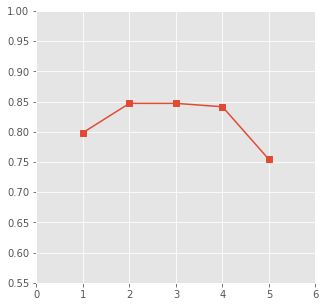

In [14]:
plt.figure(figsize=(5, 5))
plt.style.use('ggplot')
length=range(1,len(score)+1)
   
plt.plot(length,score,'s-')

# plt.title("LSTM")
# plt.xlabel("fold number")
# plt.ylabel("F1_score")
# plt.legend(loc = "best")

plt.ylim(0.55, 1)
plt.xlim(0, len(score)+1)
plt.show()

In [15]:
np.mean(score)

0.817686239040642

In [16]:
score

[0.7986102128597286,
 0.8470952634437343,
 0.847074948864232,
 0.8414410504561404,
 0.7542097195793748]

In [17]:
# # Set parameters:
# # ngram_range = 2 will add bi-grams features
# ngram_range = 2
# max_features = 20000
# maxlen = 16
# batch_size = 32
# embedding_dims = 40
# epochs = 35
# Patience = 3

# print('Loading data...')



# # # call load_data with allow_pickle implicitly set to true
# # x_train, x_test, y_train, y_test =  train_test_split(sequences, label,
# #                                                     stratify=label, 
# #                                                     test_size=0.2)



# # print(len(x_train), 'train sequences')
# # print(len(x_test), 'test sequences')
# # print('Average train sequence length: {}'.format(
# #     np.mean(list(map(len, x_train)))))
# # print('Average test sequence length: {}'.format(
# #     np.mean(list(map(len, x_test)))))

# # if ngram_range > 1:
# #     print('Adding {}-gram features'.format(ngram_range))
# #     # Create set of unique n-gram from the training set.
# #     ngram_set = set()
# #     for input_list in x_train:
# #         for i in range(2, ngram_range + 1):
# #             set_of_ngram = create_ngram_set(input_list, ngram_value=i)
# #             ngram_set.update(set_of_ngram)

# #     # Dictionary mapping n-gram token to a unique integer.
# #     # Integer values are greater than max_features in order
# #     # to avoid collision with existing features.
# #     start_index = max_features + 1
# #     token_indice = {v: k + start_index for k, v in enumerate(ngram_set)}
# #     indice_token = {token_indice[k]: k for k in token_indice}

# #     # max_features is the highest integer that could be found in the dataset.
# #     max_features = np.max(list(indice_token.keys())) + 1
# #     print("max_features:",max_features)

# #     # Augmenting x_train and x_test with n-grams features
# #     x_train = add_ngram(x_train, token_indice, ngram_range)
# #     x_test = add_ngram(x_test, token_indice, ngram_range)
# #     print('Average train sequence length: {}'.format(
# #         np.mean(list(map(len, x_train)), dtype=int)))
# #     print('Average test sequence length: {}'.format(
# #         np.mean(list(map(len, x_test)), dtype=int)))

# # print('Pad sequences (samples x time)')
# # x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
# # x_test = sequence.pad_sequences(x_test, maxlen=maxlen)
# # print('x_train shape:', x_train.shape)
# # print('x_test shape:', x_test.shape)

# print('Build model...')
# model = Sequential()

# # we start off with an efficient embedding layer which maps
# # our vocab indices into embedding_dims dimensions
# model.add(Embedding(max_features,
#                     embedding_dims,
#                     input_length=maxlen))

# # we add a GlobalAveragePooling1D, which will average the embeddings
# # of all words in the document
# model.add(GlobalAveragePooling1D())

# # We project onto a single unit output layer, and squash it with a sigmoid:
# model.add(Dense(NUM_OF_CLASS, activation='softmax'))

# model.compile(loss='sparse_categorical_crossentropy',
#               optimizer='adam',
#               metrics=['accuracy'])

# print(model.summary())
# # checkpoint = ModelCheckpoint("best.h5", monitor='val_acc', verbose=1, save_best_only=True, mode='max')
# # history = model.fit(x_train, y_train,
# #           batch_size=batch_size,
# #           epochs=epochs,
# #           validation_data=(x_test, y_test),
# #           callbacks=[EarlyStopping(monitor='val_loss', patience=Patience),checkpoint], 
# #           verbose=1 )

# # plotresult(history)

In [18]:
# model.load_weights('best.h5')
# yhat = np.argmax(model.predict(x_test),axis=1)
# f1_score(y_test,yhat,average='macro')